In [5]:
import sys
import numpy as np
import tensorflow as tf
from tensorflow.contrib.rnn import LSTMCell

from tensorflow.examples.tutorials.mnist import input_data

In [2]:
# carregando o dataset mnist
mnist = input_data.read_data_sets('/data', one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /data\train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /data\train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /data\t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /data\t10k-labels-idx1-ubyte.gz


In [7]:
if not tf.test.is_gpu_available():
    print('Não há GPU disponível!', file=sys.stderr)
else:
    print('Default GPU: {}'.format(tf.test.gpu_device_name()))

Default GPU: /gpu:0


In [ ]:
def linear(X, out_dim):
    W = tf.get_variable("W", [X.get_shape()[1], out_dim])
    b = tf.get_variable("b", [out_dim], initializer=tf.constant_initializer(.0))
    return tf.matmul(X,W)+b

21
$$
(\bar{g}_X, \bar{g}_Y, log\ \sigma^2, log\ \bar{\delta}, log\ \gamma) = W(h^{dec})
$$

22
$$
g_X = \frac{A+1}{2}\big(\bar{g}_X + 1\big)
$$

23
$$
g_Y = \frac{b+1}{2}\big(\bar{g}_Y + 1\big)
$$

24
$$
\delta = \frac{max(A, B) - 1}{n-1}\ \bar{\delta}
$$

In [147]:
def attn_window(scope, h_dec, N):
    with tf.variable_scope(scope):
        # que tal multiplicar aqui por 5 p/ ver o que acontece?
        params = linear(h_dec, N)
        print('\tattn_windom')
        print('\t\tparams: {}'.format(params.get_shape()))
    # equation 21
    gx_, gy_, logstd2, log_delta, log_gamma = tf.split(params, 5, 1)
    print('\t\tgx_: {}'.format(gx_.get_shape()))
    # equation 22
    gx = .5*(A+1)*(gx_+1)
    # equation 23
    gy = .5*(B+1)*(gy_+1)
    # equation 24
    delta = (max(A,B)-1)/(N-1)*tf.exp(log_delta)
    std2 = tf.exp(logstd2)
    return filterbank(gx, gy, std2, delta, N) + (tf.exp(log_gamma),)

\# 19
$$
\mu^i_X = g_X + (i - .5*N - .5)\ \delta
$$

\# 20
$$
\mu^j_X = g_Y + (j - .5*N - .5)\ \delta
$$

\# 25
$$
F_X[i,a] = \frac{1}{Z_X}\ exp\bigg(-\frac{\big(a-\mu^i_X\big)^2}{2\sigma^2}\bigg)
$$

\# 26
$$
F_Y[j,a] = \frac{1}{Z_Y}\ exp\bigg(-\frac{\big(a-\mu^j_Y\big)^2}{2\sigma^2}\bigg)
$$


In [129]:
def filterbank(gx, gy, sigma2, delta, N, eps=1e-8):
    grid_i = tf.reshape(tf.range(N, dtype=tf.float32), [1, -1])
    # equation 19
    mu_x = gx + (grid_i - N*.5 - .5) * delta
    # equation 20
    mu_y = gy + (grid_i - N*.5 - .5) * delta
    print('\tfilterbank')
    print('\t\tmu_x: {}'.format(mu_x.get_shape()))
    print('\t\tmu_y: {}'.format(mu_y.get_shape()))
    
    a = tf.reshape(tf.range(A, dtype=tf.float32), [1, 1, -1])
    b = tf.reshape(tf.range(B, dtype=tf.float32), [1, 1, -1])
    print('\t\ta: {}'.format(a.get_shape()))
    print('\t\tb: {}'.format(b.get_shape()))
    
    mu_x = tf.reshape(mu_x, [-1, N, 1])
    mu_y = tf.reshape(mu_y, [-1, N, 1])
    print('\t\tmu_x: {}'.format(mu_x.get_shape()))
    print('\t\tmu_y: {}'.format(mu_y.get_shape()))
    
    sigma2 = tf.reshape(sigma2, [-1, 1, 1])
    print('\t\tsigma2: {}'.format(sigma2.get_shape()))
    
    Fx = tf.exp(-tf.square(a-mu_x)/(2*sigma2))
    Fy = tf.exp(-tf.square(b-mu_y)/(2*sigma2))
    # normalizing
    Fx = Fx/tf.maximum(tf.reduce_sum(Fx, 2, keep_dims=True), eps)
    Fy = Fy/tf.maximum(tf.reduce_sum(Fy, 2, keep_dims=True), eps)
    print('\t\tFx: {}'.format(Fx.get_shape()))
    print('\t\tFy: {}'.format(Fy.get_shape()))
    return Fx, Fy

In [ ]:
def encode(lstm_enc, input, state):
    global REUSE
    with tf.variable_scope("encoder"):
        return lstm_enc(input, state)

def decode(lstm_dec, input, state):
    with tf.variable_scope("decoder"):
        return lstm_dec(input, state)

def read_no_attn(x, x_hat, h_dec_prev):
    return tf.concat([x, x_hat], 1)

In [148]:
def read_attn(x, x_hat, h_dec_prev, N):
    Fx, Fy, gamma = attn_window('read', h_dec_prev, N)
    def filter_img(img, Fx, Fy, gamma, N):
        Fxt = tf.transpose(Fx, perm=[0,2,1])
        img = tf.reshape(img, [-1, B, A])
        glimpse = tf.matmul(Fy, tf.matmul(img, Fxt))
        glimpse = tf.reshape(glimpse, [-1, N*N])
        return glimpse*tf.reshape(gamma, [-1, 1])
    x = filter_img(x, Fx, Fy, gamma, read_n)
    x_hat = filter_img(x_hat, Fx, Fy, gamma, read_n)
    return tf.concat([x, x_hat], 1)

graph = tf.Graph()
with graph.as_default():
    x = tf.placeholder(tf.float32, (2, 784))
    x_hat =  tf.random_normal((2, 784))
    h_prev = tf.random_normal((2, 256))

    print('x:      {}'.format(x.get_shape()))
    print('x hat:  {}'.format(x_hat.get_shape()))
    print('h prev: {}'.format(h_prev.get_shape()))
    result = read_attn(x, x_hat, h_prev, 5)
    print('result: {}'.format(result.get_shape()))

x:      (2, 784)
x hat:  (2, 784)
h prev: (2, 256)
	attn_windom
		params: (2, 5)
		gx_: (2, 1)
	filterbank
		mu_x: (2, 5)
		mu_y: (2, 5)
		a: (1, 1, 28)
		b: (1, 1, 28)
		mu_x: (2, 5, 1)
		mu_y: (2, 5, 1)
		sigma2: (2, 1, 1)
		Fx: (2, 5, 28)
		Fy: (2, 5, 28)
result: (2, 50)


In [90]:
def write_no_attn(h_dec, write_size):
    with tf.variable_scope('writer'):
        return linear(h_dec, write_size)

def write_attn(h_dec, write_size):
    with tf.variable_scope('writeW'):
        w = linear(h_dec, write_size)
    N = write_n
    w = tf.reshape(w, [batch_size, N, N])
    Fx, Fy, gamma = attn_window('write', h_dec, write_n)
    
    Fyt = tf.transpose(Fy, perm=[0,2,1])
    wr = tf.matmul(Fyt, tf.matmul(w, Fx))
    wr = tf.reshape(wr, [batch_size, B*A])
    return wr*tf.reshape(1./gamma, [-1, 1])

In [8]:
def sampleQ(h_enc, z_size, e):
    with tf.variable_scope('mu'):
        mu = linear(h_enc, z_size)
    with tf.variable_scope('sigma'):
        logstd = linear(h_enc, z_size)
        std = tf.exp(logstd)
    z = mu + std*e
    return z, mu, logstd, std

In [302]:
# input size
A = B = 28
img_size = A*B

# latent dimension
z_size = 100

# sequence length
T = 64

enc_size = 256
dec_size = 256

is_read_attn = is_write_attn = True

read_n  = 5
write_n = 5

# read and write size
# read_size  = 5 if is_read_attn else 2*img_size
write_size = write_n*write_n if is_write_attn else img_size

#
batch_size = 100
learning_rate = 1e-3

read  = read_attn  if is_read_attn  else read_no_attn
write = write_attn if is_write_attn else write_no_attn

graph = tf.Graph()
with graph.as_default():
    x = tf.placeholder(tf.float32, (batch_size, img_size), 'inputs')
    
    noise = tf.random_normal((batch_size, z_size), dtype=tf.float32)

    lstm_enc = LSTMCell(enc_size)
    lstm_dec = LSTMCell(dec_size)
    
    enc_state = lstm_enc.zero_state(batch_size, tf.float32)
    print('enc_state cell:   {}'.format(enc_state[0].get_shape()))
    print('enc_state hidden: {}'.format(enc_state[1].get_shape()))
    dec_state = lstm_dec.zero_state(batch_size, tf.float32)
    print('dec_state cell:   {}'.format(dec_state[0].get_shape()))
    print('dec_state hidden: {}'.format(dec_state[1].get_shape()))
    h_dec_prev = tf.zeros((batch_size, dec_size))
    print('h_dec_prev: {}'.format(h_dec_prev.get_shape()))

    c = [0]*T
    mus, logstds, stds = [0]*T, [0]*T, [0]*T
    
    with tf.variable_scope('draw') as scope:
        for t in range(T):
            if t > 0:
                scope.reuse_variables()
            cprev = tf.zeros((batch_size, img_size)) if t==0 else c[t-1]
            # x_hat is the error image
            x_hat = x - tf.sigmoid(cprev)
            # read operation
            #   without attention shape [batch_size, 1568] (784*2 the img_size)
            r = read(x, x_hat, h_dec_prev, read_n)
            #
            h_enc, enc_state = encode(lstm_enc, tf.concat([r, h_dec_prev],1), enc_state)

            z, mus[t], logstds[t], stds[t] = sampleQ(h_enc, z_size, noise)
            #
            h_dec, dec_state = decode(lstm_dec, z, dec_state)
            c[t] = cprev + write(h_dec, write_size)
            h_dec_prev = h_dec
    
    print('\n--- TRAINABLE VARIABLES ---')
    for var in tf.trainable_variables():
        print(var)

enc_state cell:   (100, 256)
enc_state hidden: (100, 256)
dec_state cell:   (100, 256)
dec_state hidden: (100, 256)
h_dec_prev: (100, 256)
	attn_windom
		params: (100, 5)
		gx_: (100, 1)
	filterbank
		mu_x: (100, 5)
		mu_y: (100, 5)
		a: (1, 1, 28)
		b: (1, 1, 28)
		mu_x: (100, 5, 1)
		mu_y: (100, 5, 1)
		sigma2: (100, 1, 1)
		Fx: (100, 5, 28)
		Fy: (100, 5, 28)
	attn_windom
		params: (100, 5)
		gx_: (100, 1)
	filterbank
		mu_x: (100, 5)
		mu_y: (100, 5)
		a: (1, 1, 28)
		b: (1, 1, 28)
		mu_x: (100, 5, 1)
		mu_y: (100, 5, 1)
		sigma2: (100, 1, 1)
		Fx: (100, 5, 28)
		Fy: (100, 5, 28)
	attn_windom
		params: (100, 5)
		gx_: (100, 1)
	filterbank
		mu_x: (100, 5)
		mu_y: (100, 5)
		a: (1, 1, 28)
		b: (1, 1, 28)
		mu_x: (100, 5, 1)
		mu_y: (100, 5, 1)
		sigma2: (100, 1, 1)
		Fx: (100, 5, 28)
		Fy: (100, 5, 28)
	attn_windom
		params: (100, 5)
		gx_: (100, 1)
	filterbank
		mu_x: (100, 5)
		mu_y: (100, 5)
		a: (1, 1, 28)
		b: (1, 1, 28)
		mu_x: (100, 5, 1)
		mu_y: (100, 5, 1)
		sigma2: (100, 1

	attn_windom
		params: (100, 5)
		gx_: (100, 1)
	filterbank
		mu_x: (100, 5)
		mu_y: (100, 5)
		a: (1, 1, 28)
		b: (1, 1, 28)
		mu_x: (100, 5, 1)
		mu_y: (100, 5, 1)
		sigma2: (100, 1, 1)
		Fx: (100, 5, 28)
		Fy: (100, 5, 28)
	attn_windom
		params: (100, 5)
		gx_: (100, 1)
	filterbank
		mu_x: (100, 5)
		mu_y: (100, 5)
		a: (1, 1, 28)
		b: (1, 1, 28)
		mu_x: (100, 5, 1)
		mu_y: (100, 5, 1)
		sigma2: (100, 1, 1)
		Fx: (100, 5, 28)
		Fy: (100, 5, 28)
	attn_windom
		params: (100, 5)
		gx_: (100, 1)
	filterbank
		mu_x: (100, 5)
		mu_y: (100, 5)
		a: (1, 1, 28)
		b: (1, 1, 28)
		mu_x: (100, 5, 1)
		mu_y: (100, 5, 1)
		sigma2: (100, 1, 1)
		Fx: (100, 5, 28)
		Fy: (100, 5, 28)
	attn_windom
		params: (100, 5)
		gx_: (100, 1)
	filterbank
		mu_x: (100, 5)
		mu_y: (100, 5)
		a: (1, 1, 28)
		b: (1, 1, 28)
		mu_x: (100, 5, 1)
		mu_y: (100, 5, 1)
		sigma2: (100, 1, 1)
		Fx: (100, 5, 28)
		Fy: (100, 5, 28)
	attn_windom
		params: (100, 5)
		gx_: (100, 1)
	filterbank
		mu_x: (100, 5)
		mu_y: (100, 5)
		

	attn_windom
		params: (100, 5)
		gx_: (100, 1)
	filterbank
		mu_x: (100, 5)
		mu_y: (100, 5)
		a: (1, 1, 28)
		b: (1, 1, 28)
		mu_x: (100, 5, 1)
		mu_y: (100, 5, 1)
		sigma2: (100, 1, 1)
		Fx: (100, 5, 28)
		Fy: (100, 5, 28)
	attn_windom
		params: (100, 5)
		gx_: (100, 1)
	filterbank
		mu_x: (100, 5)
		mu_y: (100, 5)
		a: (1, 1, 28)
		b: (1, 1, 28)
		mu_x: (100, 5, 1)
		mu_y: (100, 5, 1)
		sigma2: (100, 1, 1)
		Fx: (100, 5, 28)
		Fy: (100, 5, 28)
	attn_windom
		params: (100, 5)
		gx_: (100, 1)
	filterbank
		mu_x: (100, 5)
		mu_y: (100, 5)
		a: (1, 1, 28)
		b: (1, 1, 28)
		mu_x: (100, 5, 1)
		mu_y: (100, 5, 1)
		sigma2: (100, 1, 1)
		Fx: (100, 5, 28)
		Fy: (100, 5, 28)
	attn_windom
		params: (100, 5)
		gx_: (100, 1)
	filterbank
		mu_x: (100, 5)
		mu_y: (100, 5)
		a: (1, 1, 28)
		b: (1, 1, 28)
		mu_x: (100, 5, 1)
		mu_y: (100, 5, 1)
		sigma2: (100, 1, 1)
		Fx: (100, 5, 28)
		Fy: (100, 5, 28)
	attn_windom
		params: (100, 5)
		gx_: (100, 1)
	filterbank
		mu_x: (100, 5)
		mu_y: (100, 5)
		

	attn_windom
		params: (100, 5)
		gx_: (100, 1)
	filterbank
		mu_x: (100, 5)
		mu_y: (100, 5)
		a: (1, 1, 28)
		b: (1, 1, 28)
		mu_x: (100, 5, 1)
		mu_y: (100, 5, 1)
		sigma2: (100, 1, 1)
		Fx: (100, 5, 28)
		Fy: (100, 5, 28)
	attn_windom
		params: (100, 5)
		gx_: (100, 1)
	filterbank
		mu_x: (100, 5)
		mu_y: (100, 5)
		a: (1, 1, 28)
		b: (1, 1, 28)
		mu_x: (100, 5, 1)
		mu_y: (100, 5, 1)
		sigma2: (100, 1, 1)
		Fx: (100, 5, 28)
		Fy: (100, 5, 28)
	attn_windom
		params: (100, 5)
		gx_: (100, 1)
	filterbank
		mu_x: (100, 5)
		mu_y: (100, 5)
		a: (1, 1, 28)
		b: (1, 1, 28)
		mu_x: (100, 5, 1)
		mu_y: (100, 5, 1)
		sigma2: (100, 1, 1)
		Fx: (100, 5, 28)
		Fy: (100, 5, 28)
	attn_windom
		params: (100, 5)
		gx_: (100, 1)
	filterbank
		mu_x: (100, 5)
		mu_y: (100, 5)
		a: (1, 1, 28)
		b: (1, 1, 28)
		mu_x: (100, 5, 1)
		mu_y: (100, 5, 1)
		sigma2: (100, 1, 1)
		Fx: (100, 5, 28)
		Fy: (100, 5, 28)
	attn_windom
		params: (100, 5)
		gx_: (100, 1)
	filterbank
		mu_x: (100, 5)
		mu_y: (100, 5)
		

In [303]:
# LOSS FUNCTION
def binary_crossentropy(y, y_hat, eps=1e-8):
    return -(y*tf.log(y_hat+eps) + (1.-y)*(tf.log(1.-y_hat+eps)))
    
with graph.as_default():
    x_recons = tf.nn.sigmoid(c[-1])
    Lx = tf.reduce_sum(binary_crossentropy(x, x_recons), 1)
    Lx = tf.reduce_mean(Lx)
    
    kl_terms = [0]*T
    for t in range(T):
        mu2 = tf.square(mus[t])
        std2 = tf.square(stds[t])
        logstd = logstds[t]
        
        kl_terms[t] = .5 * tf.reduce_sum(mu2 + std2 - 2*logstd,1) - .5
    KL = tf.add_n(kl_terms)
    Lz = tf.reduce_mean(KL)
    
    cost = Lx + Lz

# OPTIMIZER
with graph.as_default():
    opt = tf.train.AdamOptimizer(learning_rate, beta1=.5)
    
    grads = opt.compute_gradients(cost)
    for i, (g,v) in enumerate(grads):
        if g is not None:
            grads[i] = (tf.clip_by_norm(g,5), v)
    train_op = opt.apply_gradients(grads)


In [282]:
from datetime import datetime

In [283]:
datetime.now()

datetime.datetime(2018, 1, 14, 13, 1, 46, 148193)

In [304]:
print('starting: {}\n'.format(datetime.now()))
train_iters=10000
Lxs = [0]*train_iters
Lzs = [0]*train_iters

with tf.Session(graph=graph) as sess:
    saver = tf.train.Saver()
#     sess.run(tf.global_variables_initializer())
    saver.restore(sess, './model/draw_attn_64.ckpt')
    
    try:
        for i in range(train_iters):
            X_train, _ = mnist.train.next_batch(batch_size)

            results = sess.run([Lx, Lz, train_op], feed_dict={x:X_train})
            Lxs[i], Lzs[i], _ = results
            print('\riter: {}; Lx: {}; Lz: {}'.format(i, Lxs[i], Lzs[i]), end='')
            if (i+1) % 1000 == 0:
                print('')
    except KeyboardInterrupt:
        print('\nTraining was interrupted!')
    finally:
        print('\nSaving the model...')
        saver.save(sess, './model/draw_attn_64.ckpt')
print('finished: {}\n'.format(datetime.now()))

starting: 2018-01-14 14:17:16.128691

iter: 999; Lx: 195.89285278320312; Lz: 3169.152832031255
iter: 1999; Lx: 173.1265869140625; Lz: 3169.4650878906255
iter: 2999; Lx: 147.07655334472656; Lz: 3171.731933593755
iter: 3999; Lx: 116.7330551147461; Lz: 3171.6042480468755
iter: 4999; Lx: 105.53948974609375; Lz: 3171.649902343755
iter: 5999; Lx: 97.69468688964844; Lz: 3171.1005859375555
iter: 6999; Lx: 80.29173278808594; Lz: 3171.197753906255
iter: 7999; Lx: 67.43507385253906; Lz: 3170.7866210937555
iter: 8999; Lx: 54.3125114440918; Lz: 3169.68920898437555
iter: 9999; Lx: 52.967708587646484; Lz: 3169.214111328125

Saving the model...
finished: 2018-01-14 16:37:33.519896



In [305]:
with tf.Session(graph=graph) as sess:
    saver = tf.train.Saver()
    saver.restore(sess, './model/draw_attn_64.ckpt')
    
    X, _ = mnist.train.next_batch(batch_size)
    
    canvas = sess.run(c, {x:X})

INFO:tensorflow:Restoring parameters from ./model/draw_attn_64.ckpt


In [287]:
import matplotlib.pyplot as plt

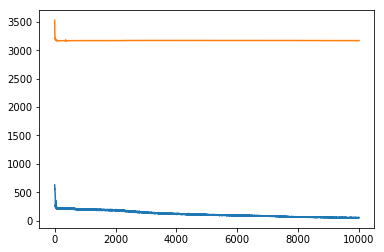

In [306]:
steps = range(train_iters)
plt.plot(steps, Lxs)
plt.plot(steps, Lzs)
plt.show()

In [307]:
images = np.array(canvas)

In [308]:
images.shape

(64, 100, 784)

In [16]:
images[:,0].shape

(10, 784)

In [309]:
images = 1./(1. + np.exp(-images))

c:\users\rodrigo\documents\envs\tensorflow_1_1_0\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

In [291]:
from matplotlib.animation import FuncAnimation, ArtistAnimation
import matplotlib.pyplot as plt

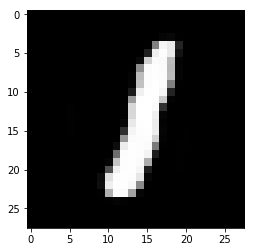

In [310]:
fig = plt.figure()
ax = fig.add_subplot(111)

ims = []
for image in images[:,0]:
    image = image.reshape(-1, 28)
    im = ax.imshow(image, cmap='gray')
    ims.append([im])

In [311]:
ani = ArtistAnimation(fig, ims)
ani.save('animation.gif', writer='imagemagick', fps=10)

plt.show()

# Generating a grid

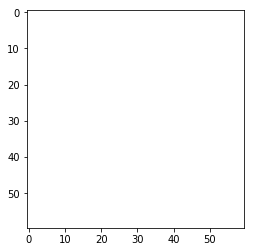

In [386]:
N = 2
padsize =  1
padval  = .5

ph = B + 2*padsize
pw = A + 2*padsize

fig, ax = plt.subplots(1, 1)

img = np.ones((N*ph, N*pw))*padval

ims = []

for t in range(T):
    samples = images[t,4:8,:].reshape((2,2,28,28))
    for i in range(N):
        for j in range(N):
            row_s = i*ph + padsize
            row_e = row_s + B

            col_s = j*pw + padsize
            col_e = col_s + A
            img[row_s:row_e, col_s:col_e] = samples[i,j,:,:]
        im = ax.imshow(img, cmap='gray')
        ims.append([im])

ani = ArtistAnimation(fig, ims)
ani.save('animation.gif', writer='imagemagick', fps=20)

plt.show()